In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

We will backtest a **long only** strategy on Apple Inc. Long only means that we only consider buying the stock. The input signal at date d says if the close price will increase at d+1. We assume that the input signal is available before the market closes.

In [18]:
df = pd.read_csv('AAPL.csv', sep=',')
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,1980-12-12,0.128348,0.128906,0.128348,0.128348,0.101073,469033600.0
1,1980-12-15,0.122210,0.122210,0.121652,0.121652,0.095800,175884800.0
2,1980-12-16,0.113281,0.113281,0.112723,0.112723,0.088768,105728000.0
3,1980-12-17,0.115513,0.116071,0.115513,0.115513,0.090965,86441600.0
4,1980-12-18,0.118862,0.119420,0.118862,0.118862,0.093603,73449600.0
...,...,...,...,...,...,...,...
10114,2021-01-25,143.070007,145.089996,136.539993,142.919998,142.919998,157611700.0
10115,2021-01-26,143.600006,144.300003,141.369995,143.160004,143.160004,98390600.0
10116,2021-01-27,143.429993,144.300003,140.410004,142.059998,142.059998,140843800.0
10117,2021-01-28,139.520004,141.990005,136.699997,137.089996,137.089996,142621100.0


1. Drop the rows with missing values and compute the daily future return on the Apple stock [`AAPL.csv`](data/AAPL.csv) on the adjusted close price. The daily future return means: **Return(t) = (Price(t+1) - Price(t))/Price(t)**.
   There are some events as splits or dividends that artificially change the price of the stock. That is why the close price is adjusted to avoid having outliers in the price data.

In [54]:
clean_data_df = df.dropna()
clean_data_df['Date'] = pd.to_datetime(clean_data_df['Date'])
clean_data_df = clean_data_df.set_index('Date')
print(clean_data_df.describe())
future_return = clean_data_df['Adj Close'].pct_change().shift(-1)
print("\n", future_return)

               Open          High           Low         Close     Adj Close  \
count  10118.000000  10118.000000  10118.000000  10118.000000  10118.000000   
mean      10.160287     10.270756     10.048267     10.163447      9.612853   
std       20.235232     20.476322     19.989577     20.242380     19.915597   
min        0.049665      0.049665      0.049107      0.049107      0.038671   
25%        0.272321      0.279018      0.265625      0.272321      0.230952   
50%        0.444196      0.450893      0.435268      0.444196      0.371715   
75%       11.668125     11.785982     11.602500     11.651339     10.051035   
max      143.600006    145.089996    141.369995    143.160004    143.160004   

             Volume  
count  1.011800e+04  
mean   3.391601e+08  
std    3.416050e+08  
min    1.388800e+06  
25%    1.305304e+08  
50%    2.266264e+08  
75%    4.220706e+08  
max    7.421641e+09  

 Date
1980-12-12   -0.052170
1980-12-15   -0.073403
1980-12-16    0.024750
1980-12-17    

2. Create a Series that contains a random boolean array with **p=0.5**

   ```console
   Here is an example of the expected time series
   2010-01-01    1
   2010-01-02    0
   2010-01-03    0
   2010-01-04    1
   2010-01-05    0
   Freq: D, Name: long_only_signal, dtype: int64
   ```

   - The information in this series should be interpreted this way:
     - On the 2010-01-01 I receive `1` before the market closes meaning that, if I trust the signal, the close price of day d+1 will increase. I should buy the stock before the market closes.
     - On the 2010-01-02 I receive `0` before the market closes meaning that, if I trust the signal, the close price of day d+1 will not increase. I should not buy the stock.

In [45]:
long_only_signal = pd.Series(np.random.randint(0, 2, size=len(clean_data_df)), 
                             index=clean_data_df.index,
                             name='long_only_signal')
print(long_only_signal)

Date
1980-12-12    1
1980-12-15    1
1980-12-16    1
1980-12-17    0
1980-12-18    1
             ..
2021-01-25    1
2021-01-26    1
2021-01-27    1
2021-01-28    0
2021-01-29    0
Name: long_only_signal, Length: 10118, dtype: int64


3. Backtest the signal created in Question 2. Here are some assumptions made to backtest this signal:
   - When, at date d, the signal equals $1$ we buy $1$ of stock just before the market closes and we sell the stock just before the market closes the next day.
   - When, at date d, the signal equals 0, we do not buy anything.
   - The profit is not reinvested, when invested, the amount is always $1$.
   - Fees are not considered

   **The expected output** is a **Series that gives for each day the return of the strategy. The return of the strategy is the PnL (Profit and Losses) divided by the invested amount**. The PnL for day d is:
   `(money earned this day - money invested this day)`

   Let's take the example of a 20% return for an invested amount of $1$. The PnL is `(1,2 - 1) = 0.2`. We notice that the PnL when the signal is 1 equals the daily return. The PnL when the signal is 0 is 0.
   By convention, we consider that the PnL of d is affected to day d and not d+1, even if the underlying return contains the information of d+1.

   **The use of a for loop is not allowed**.

In [46]:
strategy_return = long_only_signal * future_return

print(strategy_return)

Date
1980-12-12   -0.052170
1980-12-15   -0.073403
1980-12-16    0.024750
1980-12-17    0.000000
1980-12-18    0.061024
                ...   
2021-01-25    0.001679
2021-01-26   -0.007684
2021-01-27   -0.034985
2021-01-28   -0.000000
2021-01-29         NaN
Length: 10118, dtype: float64


4. Compute the return of the strategy. The return of the strategy is defined as: `(Total earned - Total invested) / Total invested`

In [56]:
total_pnl = strategy_return.sum()
total_invested = long_only_signal.sum()

total_strategy_return = total_pnl / total_invested
print(f"Total Return: {total_strategy_return} because we invested {total_invested}$ and we earned {total_pnl + total_invested}$")

Total Return: 0.0008963209897656934 because we invested 5143$ and we earned 5147.609778850365$


5. Now the input signal is: **always buy**. Compute the daily PnL and the total PnL. Plot the daily PnL of Q5 and of Q3 on the same plot

In [58]:
always_buy_signal = 1
always_buy_return = always_buy_signal * future_return
total_return = always_buy_return.sum()/ len(always_buy_return)
print("daily PnLs:\n", always_buy_return)
print("\ntotal PnLs:\n", total_return)
print(f"Total Return: {total_return} because we invested {len(always_buy_return)}$ and we earned {always_buy_return.sum() + len(always_buy_return)}$")

daily PnLs:
 Date
1980-12-12   -0.052170
1980-12-15   -0.073403
1980-12-16    0.024750
1980-12-17    0.029000
1980-12-18    0.061024
                ...   
2021-01-25    0.001679
2021-01-26   -0.007684
2021-01-27   -0.034985
2021-01-28   -0.037421
2021-01-29         NaN
Name: Adj Close, Length: 10118, dtype: float64

total PnLs:
 0.0011267019414096904
Total Return: 0.0011267019414096904 because we invested 10118$ and we earned 10129.399970243183$


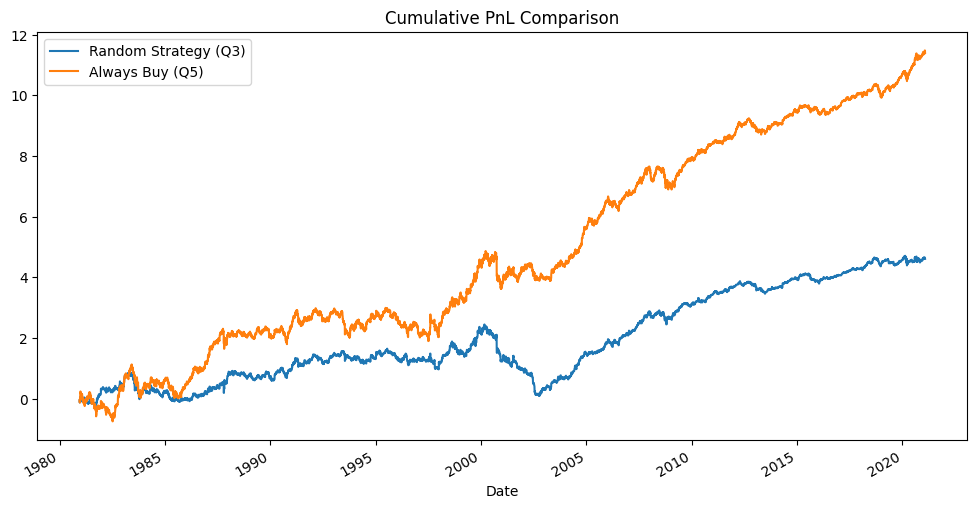

In [50]:
plt.figure(figsize=(12,6))
strategy_return.cumsum().plot(label='Random Strategy (Q3)')
always_buy_return.cumsum().plot(label='Always Buy (Q5)')
plt.title('Cumulative PnL Comparison')
plt.legend()
plt.show()